In [1]:
import numpy as np
from math import pi
from matplotlib import pyplot
from scipy.linalg import block_diag

In [12]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3
m0=9.1e-31 # kg
m=m0/10

B=10 # Tesla
hwc=hbar*(elec*B/m)
lB=np.sqrt(hbar/(elec*B))
mu_sc=20*hwc #1e2*meV
D_sc=2*hwc #10*meV
nu=1
mu_n=nu*hwc #10*meV

ky_sw=np.linspace(0,1,200)*1.5/lB
Lx=8*lB
Nx=200


def system_builder(Ls):
    kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
    [k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)

    Hx=np.diag(hbar**2 * kx**2/(2*m))

    def y2(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
        return c

    def y1(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
            c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
        return c

    def y0(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
        return c

    def y0s(k):
        with np.errstate(divide='ignore', invalid='ignore'):
            c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
            c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
        return c

    HeB2= ((elec*B)**2 * np.real(y2(k1-k2)) )/ m
    HeB2T= ((elec*B)**2 * np.real(y2(k2-k1)) )/ m
    Hef= -( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2) )
    HefT=-( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1) )
    Hd= D_sc*y0s(k1-k2) 

    Vn=np.zeros((2*Nx,2,len(ky_sw)), dtype=np.complex64)
    En=np.zeros((2*Nx,len(ky_sw)))
    for i_y in range(len(ky_sw)):
        ky=ky_sw[i_y]
        Hy=(hbar**2 * ky**2/(2*m))*np.eye(Nx)
        HeB1=-2j*hbar *ky* ( elec*B*np.imag(y1(k1-k2)))/m
        HeB1T=2j*hbar *ky* ( elec*B*np.imag(y1(k2-k1)))/m
        H1=Hx+Hy+HeB2+HeB1+Hef
        H1T=Hx+Hy+(HeB2T+HeB1T+HefT).conj()
        Hd_mat=np.kron(np.array([[0.,1.0],[0.,0.]]),Hd)
        H_t=block_diag(H1,-H1T)+Hd_mat+np.transpose(Hd_mat).conj()
        En[:,i_y], Vs =np.linalg.eigh(H_t)
        Vn[:,0,i_y]=Vs[:,Nx-1]
        Vn[:,1,i_y]=Vs[:,Nx]

    print("Done!")
    return kx,H_t,Vn,En

In [39]:
Ls1=12*lB
Ls2=2*lB

kx1,H_t1,Vn1,En1= system_builder(Ls=Ls1)
kx2,H_t2,Vn2,En2= system_builder(Ls=Ls2)

Done!
Done!


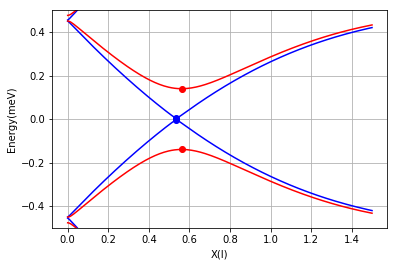

In [40]:
pyplot.figure()
pyplot.plot(ky_sw*lB,En1.T/hwc,'b')
pyplot.plot(ky_sw*lB,En2.T/hwc,'r')
pyplot.ylabel("Energy(meV)")
pyplot.xlabel("X(l)")
pyplot.ylim(-0.5,0.5)
# pyplot.ylim(-2,2)
# pyplot.xlim(-7.5,7.5)

in1=np.abs(En1[Nx-1,:]).argsort() 
ip1=np.abs(En1[Nx,:]).argsort() 
in2=np.abs(En2[Nx-1,:]).argsort() 
ip2=np.abs(En2[Nx,:]).argsort() 
# in1=np.abs(np.diff(-En1[Nx-1,:])).argsort() 
# ip1=np.abs(np.diff(En1[Nx,:])).argsort() 
# in2=np.abs(np.diff(-En2[Nx-1,:])).argsort() 
# ip2=np.abs(np.diff(En2[Nx,:])).argsort() 
pyplot.plot(ky_sw[in1[:nu]]*lB,En1[Nx-1,in1[:nu]]/hwc,'bo')
pyplot.plot(ky_sw[ip1[:nu]]*lB,En1[Nx,ip1[:nu]]/hwc,'bo')
pyplot.plot(ky_sw[in2[:nu]]*lB,En2[Nx-1,in2[:nu]]/hwc,'ro')
pyplot.plot(ky_sw[ip2[:nu]]*lB,En2[Nx,ip2[:nu]]/hwc,'ro')

pyplot.grid()
pyplot.show()


In [43]:
def wf_real_space(ev,k,x,Ls):
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x-Ls/2,[len(x),1])
    return np.dot(np.exp(1j*kt*xt),ev[:Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]), np.dot(np.exp(1j*kt*xt),ev[Nx:2*Nx,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])

ind=0
x0=np.linspace(-1,1,500)*10*lB
wf1_p,wf1_h=wf_real_space(Vn1[:,:,ip1[ind]],kx1,x0,Ls1)
wf2_p,wf2_h=wf_real_space(Vn2[:,:,ip2[ind]],kx2,x0,Ls2)

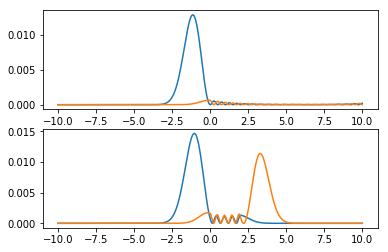

In [44]:
iwf=0
pyplot.figure()
# pyplot.plot(x0/lB,np.imag(wf1_p[:,iwf]))
# pyplot.plot(x0/lB,np.real(wf1_p[:,iwf]))
pyplot.subplot(2,1,1)
pyplot.plot(x0/lB,np.abs(wf1_p[:,iwf])**2)
pyplot.plot(x0/lB,np.abs(wf1_h[:,iwf])**2)
pyplot.subplot(2,1,2)
pyplot.plot(x0/lB,np.abs(wf2_p[:,iwf])**2)
pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf])**2)
# pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf]))
pyplot.show()

In [36]:
print(np.sum(np.abs(wf1_p[:,iwf])**2+np.abs(wf1_h[:,iwf])**2))

0.9999963512575428


In [28]:
def y0_dot(k):
    with np.errstate(divide='ignore', invalid='ignore'):
#         c = -1j*(-1+np.exp(1j*k*Lx) )/(k*np.sqrt(2*Lx+Ls1)*np.sqrt(2*Lx+Ls2))
#         c[ ~ np.isfinite( c )] = Lx /(np.sqrt(2*Lx+Ls1)*np.sqrt(2*Lx+Ls2))
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

k1=np.kron(np.ones((Nx,1)),np.reshape(kx1,[1,Nx]))
k2=np.kron(np.ones((1,Nx)),np.reshape(kx2,[Nx,1]))
Ymat=np.kron(np.eye(2),y0_dot(k2-k1))
Vb=Vn1[:,:,ip1[ind]]
Vm=Vn2[:,:,ip2[ind]]
Emat=np.diag([En2[Nx-1,in2[ind]],En2[Nx,ip2[ind]]])

VmVb=np.dot(np.transpose(Vm).conj(),np.dot(Ymat,Vb))
Hmat=np.dot(np.transpose(VmVb).conj(),np.dot(Emat,VmVb))
print(Hmat/hwc)

[[ 2.15114608e-09-9.61631278e-26j -4.80117314e-09+1.33054043e-09j]
 [-4.80117314e-09-1.33054043e-09j -2.12099310e-08+1.29705088e-24j]]


In [22]:
a=np.arange(4)
a=np.reshape(a,[1,4])
Nx=100
# print(np.kron(np.ones((Nx,1)),a))
# print(np.kron(np.ones((1,Nx)),a.T))

In [47]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3
m0=9.1e-31 # kg
m=m0/10

B=10 # Tesla
hwc=hbar*(elec*B/m)
lB=np.sqrt(hbar/(elec*B))
mu_sc=20*hwc #1e2*meV
D_sc=2*hwc #10*meV
nu=2
mu_n=nu*hwc #10*meV

ky_sw=np.linspace(0,1,300)*1.5/lB

Ls=20*lB
Lx=8*lB
Nx=100
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)

Hx=np.diag(hbar**2 * kx**2/(2*m))

def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

HeB2= ((elec*B)**2 * np.real(y2(k1-k2)) )/ m
HeB2T= ((elec*B)**2 * np.real(y2(k2-k1)) )/ m
Hef= -( 2*mu_n*np.real(y0(k1-k2)) + mu_sc*y0s(k1-k2) )
HefT=-( 2*mu_n*np.real(y0(k2-k1)) + mu_sc*y0s(k2-k1) )
Hd= D_sc*y0s(k1-k2) 

Vn=np.zeros((2*Nx,2,len(ky_sw)), dtype=np.complex64)
En=np.zeros((2*Nx,len(ky_sw)))
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy=(hbar**2 * ky**2/(2*m))*np.eye(Nx)
    HeB1=-2j*hbar *ky* ( elec*B*np.imag(y1(k1-k2)))/m
    HeB1T=2j*hbar *ky* ( elec*B*np.imag(y1(k2-k1)))/m
    H1=Hx+Hy+HeB2+HeB1+Hef
    H1T=Hx+Hy+(HeB2T+HeB1T+HefT).conj()
    Hd_mat=np.kron(np.array([[0.,1.0],[0.,0.]]),Hd)
    H_t=block_diag(H1,-H1T)+Hd_mat+np.transpose(Hd_mat).conj()
    En[:,i_y], Vs =np.linalg.eigh(H_t)
    Vn[:,0,i_y]=Vs[:,Nx-1]
    Vn[:,1,i_y]=Vs[:,Nx]
        
print("Done!")

0.0039950753230529774
0.5292062128096866
[-0.52920621  0.52920621]


Below is the code for QH-Barrier-QH only particle.

In [10]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3
m0=9.1e-31 # kg
m=m0/10

B=10 # Tesla
hwc=hbar*(elec*B/m)
lB=np.sqrt(hbar/(elec*B))
mu_sc=-20*hwc #1e2*meV

ky_sw=np.linspace(-1,1,140)*5/lB

Ls=40*lB
Lx=20*lB
Nx=200
kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
[k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)


Hx=np.diag(hbar**2 * kx**2/(2*m))

def y2(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c


HeB2= ((elec*B)**2 * np.real(y2(k1-k2)) )/ m
Hef= -mu_sc*y0s(k1-k2)

En=np.zeros((Nx,len(ky_sw)))
for i_y in range(len(ky_sw)):
    ky=ky_sw[i_y]
    Hy=(hbar**2 * ky**2/(2*m))*np.eye(Nx)
    HeB1=-2j*hbar *ky* ( elec*B*np.imag(y1(k1-k2)))/m
    H_t=Hx+Hy+HeB2+HeB1+Hef
    En[:,i_y], _ =np.linalg.eigh(H_t)
    
print("Done!")

Done!


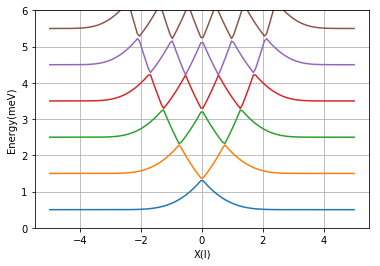

In [11]:
pyplot.figure()
# pyplot.plot(ky_sw/1e9,En.T/meV)
pyplot.plot(ky_sw*lB,En.T/hwc)
pyplot.ylabel("Energy(meV)")
# pyplot.xlabel("ky(1/nm)")
pyplot.xlabel("X(l)")
pyplot.ylim(0,6)
# pyplot.xlim(-7.5,7.5)
pyplot.grid()
pyplot.show()

In [301]:
a=np.reshape(range(4),[2,2])
b=np.reshape(range(4,8),[2,2])
Hd=sigma2+1j*sigma3
x=block_diag(a,b)+np.kron(np.array([[0.,1.0],[0.,0.]]),Hd)+np.kron(np.array([[0.,0.],[1.0,0.]]),np.transpose(Hd).conj())
print(x)

[[0.+0.j 1.+0.j 0.+1.j 0.-1.j]
 [2.+0.j 3.+0.j 0.+1.j 0.-1.j]
 [0.-1.j 0.-1.j 4.+0.j 5.+0.j]
 [0.+1.j 0.+1.j 6.+0.j 7.+0.j]]


In [348]:
print(D_sc/meV)

0.0
